In [174]:
fn1 = "margaux"
ln1 = "nicolas"
filename = "_".join(map(lambda s: s.strip().lower(),
                        ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
print(filename)

sd-tsia204_lab2_nicolas_margaux.ipynb


## SD204 - TP2 : Linear Regression

### MARGAUX NICOLAS

#### Imports

In [175]:
import scipy
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import random
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.decomposition import PCA
from tqdm import tqdm

#### Question 1 : Preprocessing of the data

##### (a) Set the random seed to 0.

In [176]:
np.random.seed(0)

##### (b) Load the data. Print the mean, and standard deviation of every covariate. Is the data centered? Normalized? Standardized?

In [177]:
df = pd.read_csv("./meatspec.csv")
df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


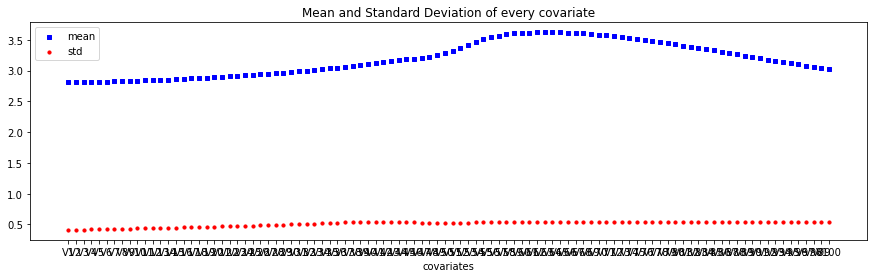

In [178]:
covariates = df.drop(['fat'], axis = 1)
output = df['fat'].values
mean = covariates.mean()
std = covariates.std()

figure = plt.figure(figsize = (15,4))
axes = figure.add_subplot(111)
axes.set_xlabel('covariates')
axes.xaxis.set_ticks(range(len(covariates.columns)))
axes.xaxis.set_ticklabels(list(covariates.columns))
axes.scatter(covariates.columns, mean, s = 10, c = 'b', marker = 's', label = 'mean')
axes.scatter(covariates.columns, std, s = 10, c = 'r', marker = 'o', label = 'std')
plt.legend(loc = 'upper left')
plt.title("Mean and Standard Deviation of every covariate")
plt.show()

In [179]:
print("Mean of every covariate : \n", mean, "\n")
print("Standard deviation of every covariate : \n", std)

Mean of every covariate : 
 V1      2.808561
V2      2.811137
V3      2.813727
V4      2.816363
V5      2.819098
          ...   
V96     3.099971
V97     3.081070
V98     3.062290
V99     3.043548
V100    3.024895
Length: 100, dtype: float64 

Standard deviation of every covariate : 
 V1      0.410793
V2      0.413352
V3      0.415906
V4      0.418465
V5      0.421040
          ...   
V96     0.540563
V97     0.539730
V98     0.538586
V99     0.537108
V100    0.535354
Length: 100, dtype: float64


As no covariate seems to have an average close to zero, the data don't seem to be centered. No value are into a range of [0,1], thus the data isn't normalized. Moreover, we can highlight that every standard deviation are around 0.5, thus data is not normalized nor standardized.

##### (c) Separate the data in train and test sets: save one fourth of the data as testing (you can use train_test_split from sklearn.model_selection) and standardize both the training and testing sets using the fit_transform and transform functions in sklearn.preprocessing.StandardScaler.

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(covariates, output, test_size = 0.25, random_state = 15)
n, p = X_train.shape

print("Train sample :", X_train.shape)
print("Test sample :", X_test.shape)

Train sample : (161, 100)
Test sample : (54, 100)


In [181]:
import sklearn.preprocessing
ss = sklearn.preprocessing.StandardScaler()

# Standardize the training and testing sets
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test) # No need to fit for the testing set
Y_train_s = ss.fit_transform(Y_train.reshape(-1,1))
Y_test_s = ss.transform(Y_test.reshape(-1,1)) #Same holds true

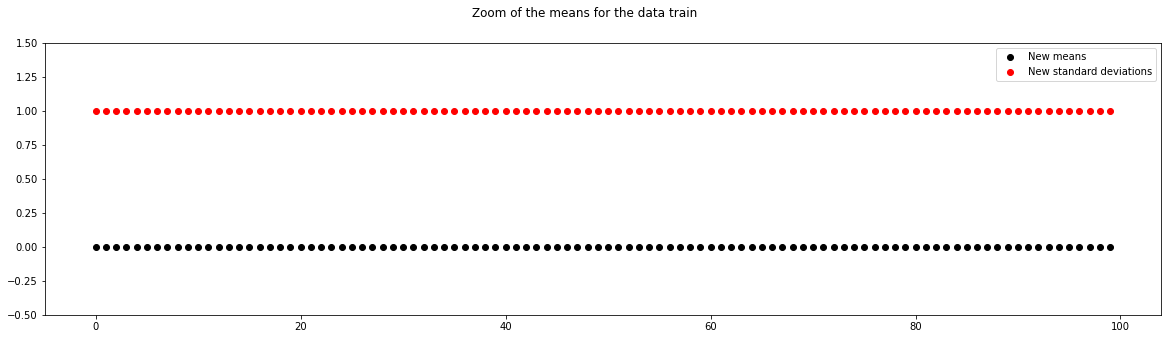

In [182]:
fig = plt.figure(figsize=(20, 5))
plt.scatter(range(X_train_s.shape[1]), X_train_s.mean(axis=0), color='k',
            label="New means")

plt.scatter(range(X_train_s.shape[1]), X_train_s.std(axis=0), color='r',
            label="New standard deviations")

plt.suptitle('Zoom of the means for the data train')
plt.ylim((-0.5, 1.5))
plt.legend()

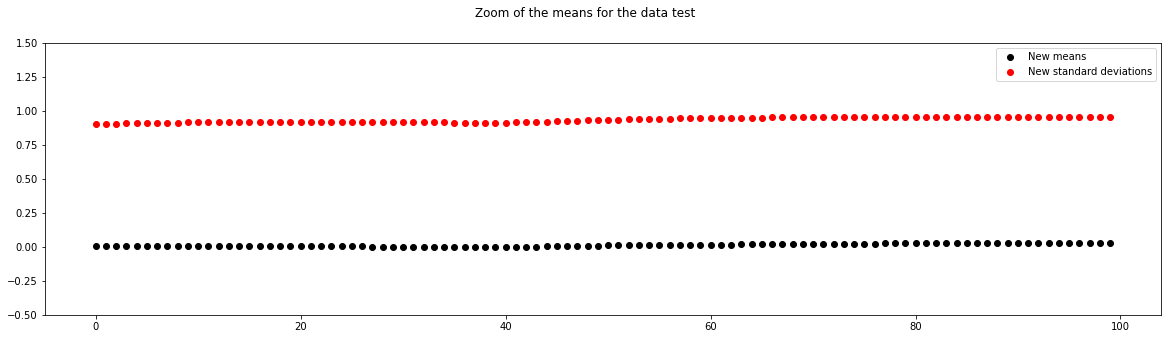

In [183]:
fig = plt.figure(figsize=(20, 5))
plt.scatter(range(X_test_s.shape[1]), X_test_s.mean(axis=0),
            color='k', label="New means")

plt.scatter(range((X_test_s.shape[1])), X_test_s.std(axis=0),
            color='r', label="New standard deviations")

plt.suptitle('Zoom of the means for the data test')
plt.ylim((-0.5, 1.5))
plt.legend()

The train and test data are now scaled (with a mean around 0 and a standard deviation nearly equals to 1)

##### (d) Fit a regular OLS, do we need to fit the intercept ?

In [184]:
# Train the model
reg = LinearRegression(fit_intercept = False).fit(X_train_s, Y_train_s)

# Print the coefficients
print('Coefficients:', reg.coef_)

# Print the intercept
print('Intercept:', reg.intercept_)

# Print the R-squared value
print('R-squared:', reg.score(X_test_s, Y_test_s))

Coefficients: [[  192.17574722    45.63700047 -1073.45987691  2439.53147241
  -3250.13151867  2722.22724869 -1141.41935664  -248.2089464
    -32.12049823   487.81032622 -1164.18753042  1727.9372208
  -1344.07017034   754.33831127   899.66387217 -1146.24875406
   -417.61017742   896.84466613   -96.57094249   -30.25366867
  -1643.07228451  2523.13004391 -1138.82991594   115.15483115
   -221.89745827    43.2490701    -82.87308123  1054.46638347
   -983.37923654  -588.81680387  1567.42008149 -1847.49387115
   2125.24985343 -1884.97772754   700.06226916    92.30796713
   -370.70721814   214.71564744   485.43560582  -654.0929433
    824.13877922  -235.7702062  -1072.87240688   297.56011133
   1187.81841843  -581.09605492  -247.44991963   143.28608411
   -276.61979498   -49.65796311  1492.86737715 -2561.85055969
   1663.32728663   430.42097047 -1458.69129882   792.67549264
     69.20143459    76.91690542  -833.71781177   685.89547798
    197.55563689  -498.38197652   606.75944484  -331.355466

This code creates an instance of the LinearRegression class from scikit-learn, fits it to the input data (X_train, Y_train), and then prints the coefficients, intercept, and R-squared value for the fit.
In linear regression, the intercept term represents the value of the dependent variable when all independent variables are zero. The need to include an intercept term in a linear regression model depends on the context of the problem and the data being analyzed.
If there is no theoretical or practical reason to believe that the intercept is zero, it should be included. Yet, in our case, if the 100 covariates representing 100 channel spectrum of absorbances are all equal to 0, necessarily the fat will be equal to 0. In this case, including an intercept is not necessary.
Another reason to exclude the intercept is that we've centered the data.

##### (e) Create a dataFrame df_coef and store the R2 coefficients of the estimated model. This data frame will be used along the TP to store and compare R2 coefficients of other variants of the OLS problem.

In [185]:
# Create a dataframe storing the R2 coefficient of all the variants seen during the TP
df_coef = pd.DataFrame({'Variant': [],
                        'R2 coefficient': []})

# Add the first row corresponding to the first R2 computed with the regular OLS estimator
df_coef.loc[len(df_coef)] = ['Regular OLS', reg.score(X_test_s, Y_test_s)]
df_coef

,Variant,R2 coefficient
0,Regular OLS,0.935114


#### Question 2 : Variable selection

##### Program the method of the forward variable selection. You can use the test statistics of the test for nullity (as seen during the course). Do not define the stop criterion for the method, i.e. add a variables at each time until all the variables are used. Store the order of the variable selection and the associated p-value for each of them.

In [186]:
def forward_variable_selection(X, Y):

    # Initializating the variables
    n,p = X.shape
    z = Y.copy()

    p_values = []
    selected_variables = [] # initialize empty variables list
    remaining_variables = [i for i in range(p)] # initialize result variable list

    for i in range(p):
        # Initializing the variables before an iteration
        pred = np.zeros((p,n, 1))
        T = np.zeros(p)

        for k in remaining_variables :
            X_hat = np.stack((np.ones(n), X[:, k]), axis=1) # With the first column filled of ones
            gram_matrix = X_hat.T@X_hat/n
            theta = LinearRegression(fit_intercept = False).fit(X[:, k:k+1], z).coef_
            pred[k] = X[:, k:k+1]@theta.T
            sigma = np.linalg.norm(z-pred[k])**2/(n-2)
            inverse = np.sqrt(np.linalg.inv(gram_matrix)[1,1])
            val = (np.linalg.norm(theta)*np.sqrt(n))/(sigma*inverse)
            T[k] = val

        # Now, let's search the best variable and calculate the p-value associated
        index_best_var = np.argmax(T)
        p_value = 2*(1-stats.t.cdf(max(T), n-2))

        # Updating the variables
        remaining_variables.remove(index_best_var)
        selected_variables.append(index_best_var)
        p_values.append(p_value)
        z = z-pred[index_best_var]
    
    return np.array(selected_variables).flatten(), np.array(p_values).flatten()

selected_variables, p_values = forward_variable_selection(X_train_s, Y_train_s)
print("The selected variables are in this order :", selected_variables, "and the associated p-value for each of them are", p_values)

The selected variables are in this order : [40  6 39  7 41  5 38  8 42  4 37  9 36  3 97 10 43  2 35 11 98  1 34 12
 96  0 99 13 33 14 44 15 95 16 32 17 94 63 93 64 31 18 45 62 92 65 91 61
 90 66 30 60 89 67 88 19 46 68 87 59 29 58 86 69 85 54 84 53 28 55 83 57
 47 56 82 70 27 20 81 52 26 71 80 51 48 72 79 73 25 21 78 50 24 74 77 75
 23 22 49 76] and the associated p-value for each of them are [2.22044605e-16 1.24566709e-02 1.21582449e-02 1.13974193e-02
 1.18207159e-02 1.11127519e-02 1.14738922e-02 1.09488706e-02
 1.38302494e-02 1.32800566e-02 1.28267864e-02 1.24757639e-02
 1.71614369e-02 1.66535055e-02 1.80644344e-02 2.07244716e-02
 2.06181711e-02 2.06813513e-02 2.26060077e-02 2.25799891e-02
 2.45870547e-02 2.86594362e-02 3.26725530e-02 3.29611791e-02
 3.34759922e-02 3.91346278e-02 4.68111900e-02 5.41026334e-02
 5.09841651e-02 5.58309856e-02 5.58215743e-02 6.31767019e-02
 7.83205011e-02 9.75464161e-02 1.01295962e-01 1.16544774e-01
 1.33255870e-01 1.52808556e-01 1.71967038e-01 1.761374

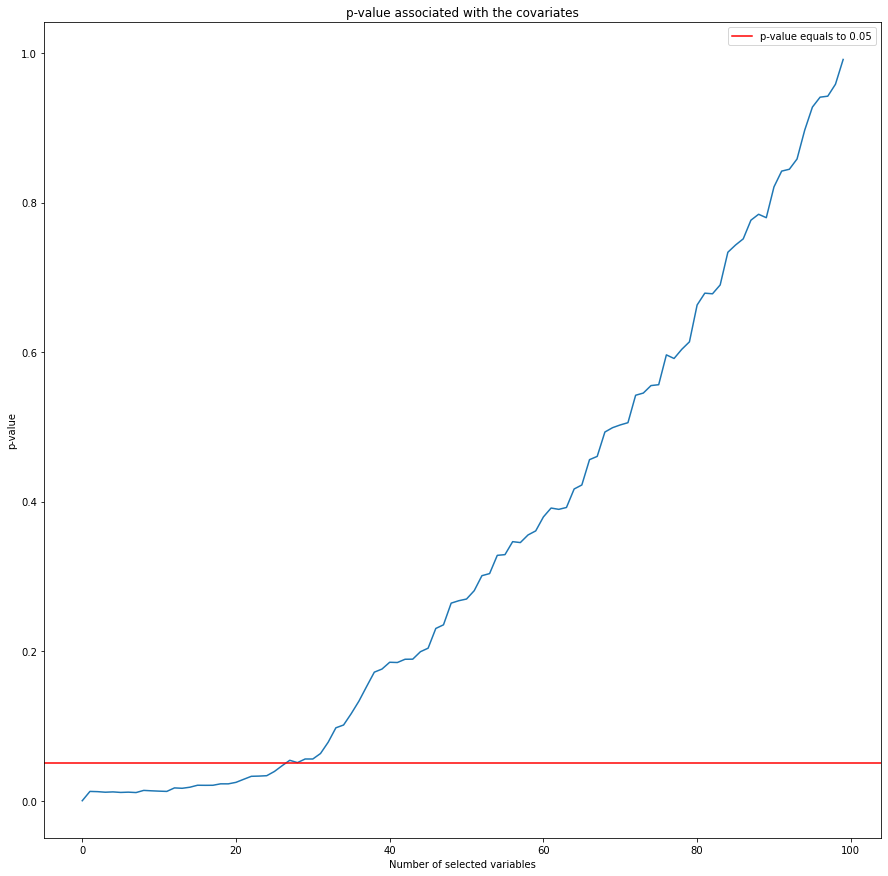

In [187]:
# Ploting the results of the previous function
plt.figure(figsize=(15,15))
plt.plot(p_values)
plt.axhline(0.05, c='r', label='p-value equals to 0.05')
plt.xlabel('Number of selected variables')
plt.ylabel('p-value')
plt.title('p-value associated with the covariates')
plt.legend()
plt.show()

As our list of selected variables is already sorted, if we only search for the first p-value > 0,05, we'll get all the covariates with a p-value smaller than 0,05.

#### Question 3 : Run OLS on the variables with a p-value smaller than 0.05.

##### (a) Apply the OLS of the sklearn library.
##### (b) Store the R2 coefficient in df_coef.

In [188]:
# First, let's find the index for which the p-value is > 0,05
stop_criterion = 0.05
index = 0
while index + 1 < len(p_values) and p_values[index+1] < stop_criterion:
    index+=1

# Checking if there is no problem
print(p_values[index])
print(p_values[index+1])

print('Number os variables fitting with the stop_criterion =', index+1)
print('Selected variables :', selected_variables[:index+1])

0.046811190028798855
0.05410263343203936
Number os variables fitting with the stop_criterion = 27
Selected variables : [40  6 39  7 41  5 38  8 42  4 37  9 36  3 97 10 43  2 35 11 98  1 34 12
 96  0 99]


In [189]:
X_train_varselect = np.zeros((n, index+1))
X_test_varselect = np.zeros((X_test_s.shape[0], index+1))
for i, k in enumerate(selected_variables[:index+1]):
    X_train_varselect[:, i] = X_train_s[:, k]
    X_test_varselect[:, i] = X_test_s[:, k]

# Performing the OLS on the our train and test new subsets and store the R2 coefficient in the dataframe created earlier
reg = LinearRegression(fit_intercept=False).fit(X_train_varselect, Y_train_s)
df_coef.loc[len(df_coef)] = ['OLS with the selected variables', reg.score(X_test_varselect, Y_test_s)]
df_coef

,Variant,R2 coefficient
0,Regular OLS,0.935114
1,OLS with the selected variables,0.949945


#### Question 4 : Using SequentialFeatureSelector on a linear regression estimator select (with forward selection), select the same number of variables as in the previous question.

In [190]:
# Create an instance of the SequentialFeatureSelector
sfs = SFS(LinearRegression(fit_intercept=False), n_features_to_select=index+1)

# Fit the SFS to the data
sfs.fit(X_train_s, Y_train_s)

# Get the selected features
X_train_sfs = sfs.transform(X_train_s)
X_test_sfs = sfs.transform(X_test_s)

selection = sfs.get_support()
selected_variables = np.array(range(p))[selection]

print('Number of variables we kept =', X_train_sfs.shape[1])
print('Selected variables :', selected_variables)

# Performing the OLS on the our train and test new subsets and store the R2 coefficient in the dataframe created earlier
reg = LinearRegression(fit_intercept=False).fit(X_train_sfs, Y_train_s)
df_coef.loc[len(df_coef)] = ['SequentialFeatureSelector', reg.score(X_test_sfs, Y_test_s)]
df_coef

Number of variables we kept = 27
Selected variables : [ 0 18 21 27 33 34 35 36 37 38 40 41 42 44 46 47 48 57 58 59 69 75 86 89
 96 98 99]


,Variant,R2 coefficient
0,Regular OLS,0.935114
1,OLS with the selected variables,0.949945
2,SequentialFeatureSelector,0.944030


##### (a) Elaborate on why the 2 algorithms do not return the same variables and store the R2 onto the corresponding dataFrame.

As the selecting criterion between the two algorithms (SFS and OLS with selecting criterion on p-value) isn't the same, the covariates on the output are not the same.

#### Question 5 : Code your own ridge estimator using expression derived in class. Test it for a penalty parameter α spaced evenly on a log scale 10e-9 to 10e2

In [193]:
# Function that computes the ridge estimator
def ridge_estimator(X, Y, alpha):
    n,p = X.shape
    return np.linalg.inv(X.T@X+n*alpha*np.eye(p))@X.T@Y

##### (a) Plot how the values of the coefficients change with α.

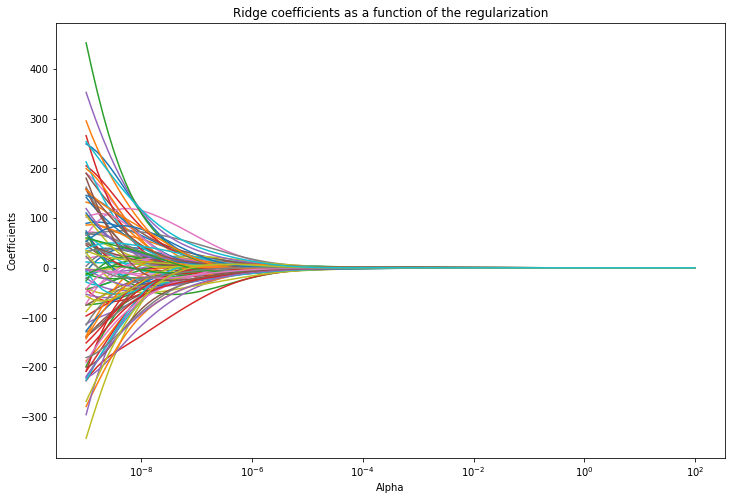

In [194]:
# Create an array of alpha values
alphas = np.logspace(-9, 2, 110)

# Create an empty array to store the coefficients
coefs_rg = np.zeros((len(alphas), X_train_s.shape[1]))

# Fit a Ridge model for each alpha value
for i, alpha in enumerate(alphas):
    coefs_rg[i] = ridge_estimator(X_train_s, Y_train_s, alpha).reshape(p,)
    
# Plot the coefficients as a function of alpha
plt.figure(figsize=(12, 8))
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.plot(alphas, coefs_rg)
plt.show()

##### (b) Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

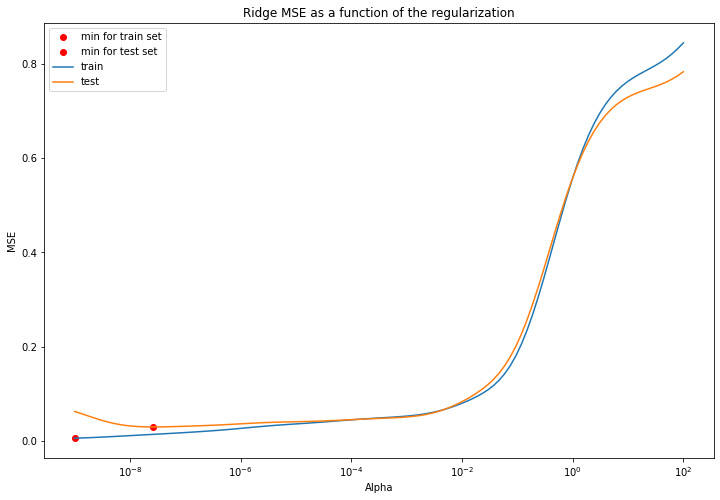

In [195]:
# Create empty lists to store the MSE values
train_mse_rg = np.zeros(len(alphas))
test_mse_rg = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
  train_mse_rg[i] = mean_squared_error(Y_train_s, X_train_s @ coefs_rg[i])
  test_mse_rg[i] = mean_squared_error(Y_test_s, X_test_s @ coefs_rg[i])

# Plot the MSE as a function of alpha
plt.figure(figsize=(12, 8))
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.scatter(alphas[np.argmin(train_mse_rg)], np.min(train_mse_rg), marker='o', color='red', label='min for train set')
plt.scatter(alphas[np.argmin(test_mse_rg)], np.min(test_mse_rg), marker='o', color='red', label='min for test set')
plt.title('Ridge MSE as a function of the regularization')
plt.plot(alphas, train_mse_rg, label='train')
plt.plot(alphas, test_mse_rg, label='test')
plt.legend()
plt.show()

##### (c) For the best performing value of α (the one with smallest training error) store the R2 results.

In [197]:
# Store the R2 coefficient in the dataframe created earlier
df_coef.loc[len(df_coef)] = ['Ridge Estimator', r2_score(Y_test_s, X_test_s@coefs_rg[np.argmin(test_mse_rg)])]
df_coef

,Variant,R2 coefficient
0,Regular OLS,0.935114
1,OLS with the selected variables,0.949945
2,SequentialFeatureSelector,0.944030
3,Ridge Estimator,0.966418
4,Ridge Estimator,0.966418


#### Question 6 : Crossvalidation, Lasso and elastic net : Use the sklearn version of the Lasso. Test it for a penalty parameter α spaced evenly on a log scale 10e-5 to 10e-2.

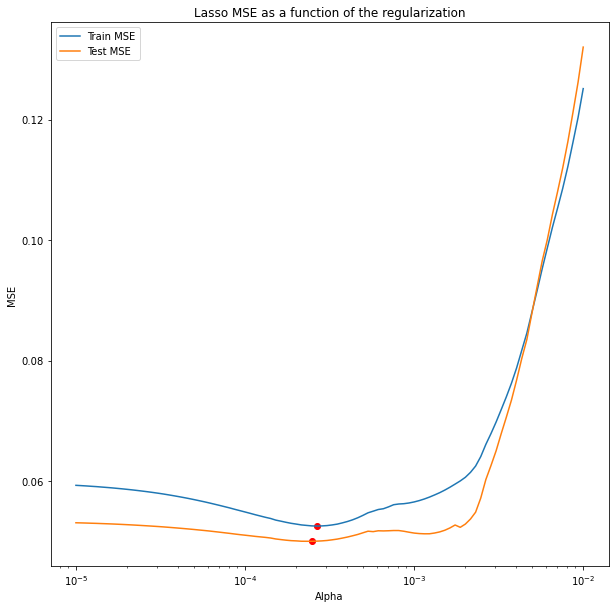

In [198]:
# Create an array of alpha values and empty lists to store the MSE values
alphas = np.logspace(-5, -2, 100)
train_mse_lasso = np.zeros(len(alphas))
test_mse_lasso = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
    # We use the lasso function stored in the library, taking into account the hint of decreasing the parameter tol or increasing max_iter
    lasso = Lasso(alpha=alpha, max_iter=50000, tol=0.03).fit(X_train_s, Y_train_s)
    Y_train_lasso = lasso.predict(X_train_s)
    Y_test_lasso = lasso.predict(X_test_s)
    
    # Now, let's store the mean squared error
    train_mse_lasso[i] = mean_squared_error(Y_train_s, Y_train_lasso)
    test_mse_lasso[i] = mean_squared_error(Y_test_s, Y_test_lasso)
    
# Plotting the MSE as a function of alpha
plt.figure(figsize=(10, 10))
plt.plot(alphas, train_mse_lasso, label='Train MSE')
plt.plot(alphas, test_mse_lasso, label='Test MSE')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso MSE as a function of the regularization')
plt.scatter(alphas[np.argmin(train_mse_lasso)],np.min(train_mse_lasso),marker='o',color='red')
plt.scatter(alphas[np.argmin(test_mse_lasso)],np.min(test_mse_lasso),marker='o',color='red')
plt.legend()
plt.show()

##### (a) To avoid having warnings and error you want to decrease the parameter tol or increase max_iter. Elaborate on why these warning arise and on the solution.


##### answer : When training a model using scikit-learn, the tol parameter is used to set the tolerance for convergence. If the difference between the previous and current values of the cost function is less than tol, the training process will stop. The max_iter parameter sets the maximum number of iterations the training process will run for.

##### If the tol parameter is set too high, the training process may not converge and will continue running indefinitely. This can cause a warning to be raised. Similarly, if max_iter is set too low, the training process may not converge within the specified number of iterations and will also raise a warning.

##### To avoid these warnings, you can decrease the tol parameter or increase the max_iter parameter. Decreasing tol will make the training process more sensitive to changes in the cost function and will cause it to stop training sooner when it reaches a satisfactory level of convergence. Increasing max_iter will allow the training process to run for a longer period of time, which will increase the chances of it converging.

##### It's worth to note that when you increase max_iter without decreasing tol and the model is not converging, you may end up overfitting, which is not the desired outcome. Also, decreasing tol too much may make the model not to converge and also not generalize well.

##### (b) Plot the number of coefficients that are different from 0 for each value of α.
##### (c) Plot how MSE of both the train and test sets change with α. Signal the minimum with a point.

C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.919e+00, tolerance: 1.610e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.916e+00, tolerance: 1.610e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.912e+00, toleranc

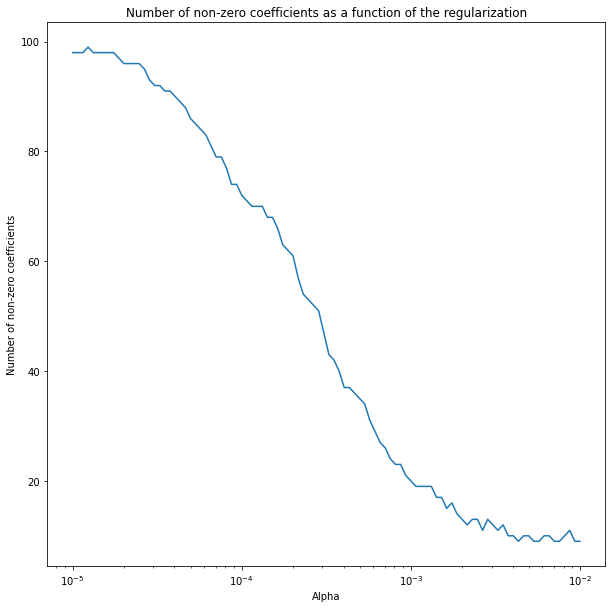

In [199]:
# Create an empty list to store the number of non-zero coefficients
non_zero_coefs = np.zeros(len(alphas))

# Loop over the range of alpha values
for i, alpha in enumerate(alphas):
    # Create a Lasso object
    lasso = Lasso(alpha=alpha, fit_intercept = False, max_iter = 10000, tol = 1e-3)
    # Fit the model to the data
    lasso.fit(X_train_s, Y_train_s)
    # Count the number of non-zero coefficients and store the result
    coefs_lasso = lasso.coef_
    non_zero_coefs[i] = len(coefs_lasso[np.abs(coefs_lasso) > 1e-8]) # Here we apply a thresh to consider if a coef is null or not

# Plot the number of non-zero coefficients against the alpha values
plt.figure(figsize=(10,10))
plt.plot(alphas, non_zero_coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Number of non-zero coefficients')
plt.title('Number of non-zero coefficients as a function of the regularization')
plt.show()

##### (d) For the best performing value of α on the test set store the R2 results.

In [200]:
best_alpha = alphas[np.argmin(train_mse_lasso)]

# Let's perform the Lasso method with the best alpha
lasso = Lasso(alpha=best_alpha, fit_intercept = False, max_iter = 10000, tol = 1e-3)
# Fit the model to the data
lasso.fit(X_train_s, Y_train_s)

# Store the R2 coefficient in the dataframe created earlier
df_coef.loc[len(df_coef)] = ['Lasso', lasso.score(X_test_s, Y_test_s)]
df_coef

C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.568e-01, tolerance: 1.610e-01
  model = cd_fast.enet_coordinate_descent(


,Variant,R2 coefficient
0,Regular OLS,0.935114
1,OLS with the selected variables,0.949945
2,SequentialFeatureSelector,0.944030
3,Ridge Estimator,0.966418
4,Ridge Estimator,0.966418
5,Lasso,0.946154


#### Question 7 :  Code your own version of the crossvalidation. Preferable, in the same way as sklearn’s version, the length of every pair of folds should differ at most by one. Use the sklearn version of the Elastic net. Validate with a cross-validation that you implement. Test it for a penalty parameter α-ridge spaced evenly on a log scale 10e-10 to 10e3 and α-lasso in [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99].

In [201]:
def cross_validation_score(estimator, X, Y, n_splits = 5):
    n = len(Y)
    split_size = n//n_splits
    remaining_nb = n%n_splits # Number of samples that we have to distribute after split_size
    premier_index = 0
    scores = []
    
    for i in range(n_splits):
        # Determine the test size's length
        if remaining_nb > 0:
            i_split_size = split_size + 1
            remaining_nb -= 1
            
        else :
            i_split_size = split_size
            
        # Creating train and test subsets
        dernier_index = premier_index + i_split_size
        X_test_kfold = X[premier_index:dernier_index]
        Y_test_kfold = Y[premier_index:dernier_index]
        X_train_kfold = np.concatenate((X[:premier_index], X[dernier_index:]))
        Y_train_kfold = np.concatenate((Y[:premier_index], Y[dernier_index:]))
        
        # Fitting the model + computing the r2
        r2 = estimator.fit(X_train_kfold, Y_train_kfold).score(X_test_kfold, Y_test_kfold)
        scores.append(r2)
        premier_index = dernier_index
        
    return np.array(scores)

print('Cross validation with 5 splits', cross_validation_score(Lasso(alpha=best_alpha, fit_intercept = False, max_iter = 10000, tol = 1e-3), X_train_s, Y_train_s))

C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.237e-01, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e-01, tolerance: 1.295e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.754e-01, toleranc

Cross validation with 5 splits [0.94453217 0.94132565 0.9412725  0.94160198 0.94811553]


C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.862e-01, tolerance: 1.272e-01
  model = cd_fast.enet_coordinate_descent(


In [151]:
# Let's test the cross validation we've just implemented with the alphas defined earlier
alphas = np.logspace(-10, 3)
l1_ratios = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]

best_alpha_kfold = None
best_l1_ratios_kfold = None
best_score = 0

for alpha in tqdm(alphas):
    for l1_ratio in l1_ratios:
        score = cross_validation_score(ElasticNet(fit_intercept=False, alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, tol = 1e-3), X_train_s, Y_train_s).mean()
        
        if score > best_score:
            best_score = score
            best_alpha_kfold = alpha
            best_l1_ratio_kfold = l1_ratio

print('Le meilleur alpha est', best_alpha_kfold)
print('Le meilleur l1_ratio est', best_l1_ratio_kfold)


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 1.288e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+00, tolerance: 1.295e-01 Linear regression models with null 

Le meilleur alpha est 6.866488450043012e-05
Le meilleur l1_ratio est 0.95


In [202]:
# Store the R2 coefficient in the dataframe created earlier
score = ElasticNet(fit_intercept=False, alpha=best_alpha_kfold, l1_ratio=best_l1_ratio_kfold, max_iter=10000, tol=1e-3).fit(X_train_s, Y_train_s).score(X_test_s, Y_test_s)
df_coef.loc[len(df_coef)] = ['Crossvalidation and ElasticNet', score]
df_coef

C:\Users\marga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.365e+00, tolerance: 1.610e-01
  model = cd_fast.enet_coordinate_descent(


,Variant,R2 coefficient
0,Regular OLS,0.935114
1,OLS with the selected variables,0.949945
2,SequentialFeatureSelector,0.944030
3,Ridge Estimator,0.966418
4,Ridge Estimator,0.966418
5,Lasso,0.946154
6,Crossvalidation and ElasticNet,0.948832


#### Question 8 : Bootstrap : For this question, we are going to use only variable 40 of the dataset original (non-centered) X. Plot the dataset and the regression line fitted with the whole sample. Generate 50 bootstrap samples, for each of the samples fit a regression model and plot the 50 estimated regression lines in the same plot (by setting alpha=.4 in the plotting function you can make the lines more transparent for the sake of readability of the plot). Finally, in the same plot, plot the prediction intervals (see exercise 12 in the lecture notes for the expression of the confidence intervals for the one dimensional case).

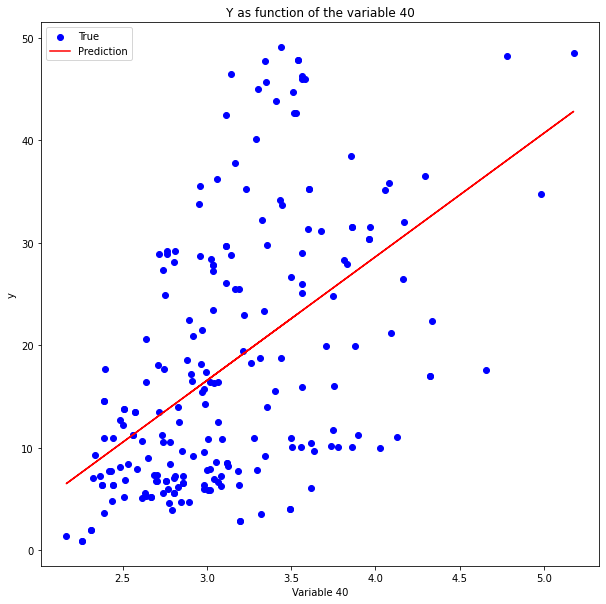

In [203]:
# Select only variable 40 from the dataset
n = len(output)
X_var40 = covariates.to_numpy()[:, 40].reshape(n)

# Fit a linear regression model using the selected variable
reg = LinearRegression().fit(X_var40.reshape(-1,1), output)

# Plot the data and the regression line
plt.figure(figsize=(10,10))
plt.scatter(X_var40, output, color='blue', label='True')
plt.plot(X_var40, reg.predict(X_var40.reshape(-1,1)), color='red', label='Prediction')
plt.xlabel('Variable 40')
plt.ylabel('y')
plt.legend()
plt.title('Y as function of the variable 40')
plt.show()

In [204]:
# function to generate 50 bootstrap samples
def bootstrap(X, Y, N):
    n_samples = X.shape[0]
    X_var40_bootstrap = np.empty((N, n, p))
    Y_bootstrap = np.empty((N, n))
    for j in range(N):
        for k in range(n):
          i = np.random.randint(n)
          X_var40_bootstrap[j, k] = X[i]
          Y_bootstrap[j, k] = Y[i]
    return X_var40_bootstrap, Y_bootstrap

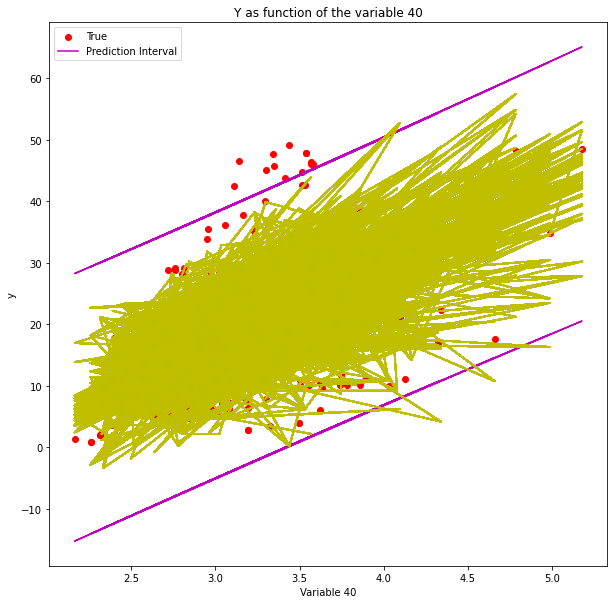

In [205]:
# Defining the variables
X_var40_bootstrap, Y_bootstrap = bootstrap(X_var40, output, 50)

# Fit a linear regression model to each bootstrap sample
regs = LinearRegression().fit(X_var40.reshape(-1,1), output)

# Plotting the reference
plt.figure(figsize=(10, 10))
plt.scatter(X_var40, output, color='r', label='True')
plt.title('Y as function of the variable 40')

# Compute the predictions and the prediction intervals for each bootstrap sample
predictions = reg.predict(X_var40.reshape(-1,1))
variance = np.sum((output - predictions)**2) / (n - 2)
alpha = 0.05 # Classic choice
quantile = stats.t.ppf(1-alpha/2, n-2)

lower_bound = predictions-quantile*np.sqrt(variance*(1+1/n+(X_var40-np.mean(X_var40))**2/np.sum((X_var40-np.mean(X_var40))**2)))
upper_bound = predictions+quantile*np.sqrt(variance*(1+1/n+(X_var40-np.mean(X_var40))**2/np.sum((X_var40 - np.mean(X_var40))**2)))

# Plotting the prediction intervals
plt.plot(X_var40, lower_bound, c='m', label='Prediction Interval')
plt.plot(X_var40, upper_bound, c='m')

# Plot the data and the estimated regression lines
for i in range(50):
    predictions = LinearRegression().fit(X_var40_bootstrap[i], Y_bootstrap[i]).predict(X_var40_bootstrap[i])
    plt.plot(X_var40_bootstrap[i], predictions, alpha=0.4, c='y')
plt.xlabel('Variable 40')
plt.ylabel('y')
plt.legend()
plt.show()

#### Question 9 : PCA : Compute the covariance matrix. Compute the singular value decomposition of the covariance matrix.


In [167]:
n = len(Y_train_s)
scaled_cov = X_train_s.T@X_train_s/(n-1)
U,s,V = np.linalg.svd(scaled_cov, full_matrices = True)

print("U shape :", U.shape, ", s shape :", s.shape, ", V shape :", V.shape)
print("Principal components associated to the eigenvalues values :", s[0], "and", s[1])

U shape : (100, 100) , s shape : (100,) , V shape : (100, 100)
Principal components associated to the eigenvalues values : 99.34982680597051 and 0.8824437275089146


##### (a) Plot a heatmap of the covariance matrix.

<AxesSubplot:>

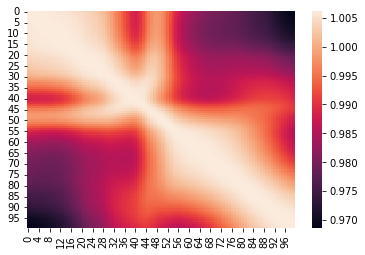

In [206]:
sns.heatmap(scaled_cov)

The covariance for each covariate differs a lot from one column to another. We can see that some values are highly correlated (bright spots).

##### (b) In PCA we transform the data to a new coordinate system such that the greatest variance by some scalar projection of the data lies on the first coordinate (called the first principal component, PC1), the second greatest variance in the second PC and so on. The PCs are computed given the above SVD, as XU. Instead of using the whole transformation, XU.
##### (c) Plot the amount of variance explained by the first k components for k P 2..p.

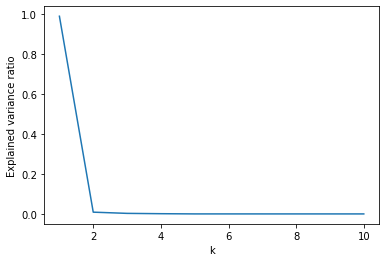

In [207]:
# Perform PCA on the data
pca = PCA()
pca.fit(X_train_s)

# Compute the explained variance ratio for each of the first k components
k = 10
explained_variance = pca.explained_variance_ratio_[:k]

# Plot the explained variance ratio for each of the first k components
plt.plot(range(1, k+1), explained_variance)
plt.xlabel('k')
plt.ylabel('Explained variance ratio')
plt.show()

##### (d)  We will use (as an approximation) the first 2 PCs. Plot the projected data using as color the value of y and interpret the plot.

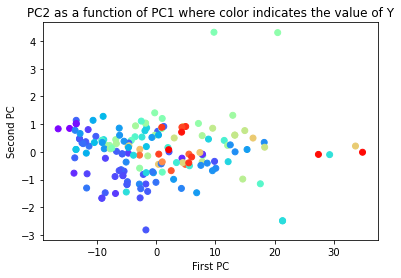

In [208]:
# Perform PCA on the data and project the data onto the first 2 PCs
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X_train_s)

# Plot the projected data using the value of y as the color
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=Y_train_s, cmap='rainbow')
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.title('PC2 as a function of PC1 where color indicates the value of Y')
plt.show()

##### (e)  Run OLS on the projected data using k components for k evenly spaced in 2..p. Store the best score in the dataFrame.

Best score is obtained with 35 main components


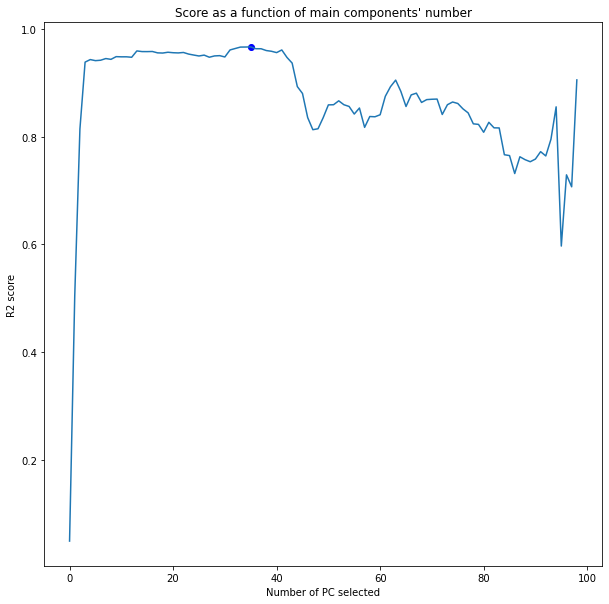

,Variant,R2 coefficient
0,Regular OLS,0.935114
1,OLS with the selected variables,0.949945
2,SequentialFeatureSelector,0.944030
3,Ridge Estimator,0.966418
4,Ridge Estimator,0.966418
5,Lasso,0.946154
6,Crossvalidation and ElasticNet,0.948832
7,OLS with PCA,0.966456


In [209]:
# Now let's run PCA with k components
# First, create an array to store the results
results = []
for k in range (2, p+1):
    X_train_PCA = X_train@U[:, :k]
    X_test_PCA = X_test@U[:, :k]

# Run OLS on the projected data using k components for k evenly spaced in 2..p
    reg = LinearRegression(fit_intercept = False).fit(X_train_PCA, Y_train_s)
    score = reg.score(X_test_PCA, Y_test_s)
    results.append(score)
    
results = np.array(results)
print('Best score is obtained with', results.argmax(), 'main components')
plt.figure(figsize=(10, 10))
plt.plot(range(p-1), results)
plt.scatter(results.argmax(), results.max(),marker='o',color='blue')
plt.title("Score as a function of main components' number")
plt.xlabel('Number of PC selected')
plt.ylabel('R2 score')
plt.show()

# Store the best score in the dataframe
df_coef.loc[len(df_coef)] = ['OLS with PCA', results.max()]
df_coef

#### Question 10 : Comparison of the models

##### (a) Summarize the results of the models and elaborate in their main characteristics.

OLS:
OLS is a linear regression method that estimates the coefficients of a linear model by minimizing the sum of squared residuals. OLS assumes that all the predictor variables are independent of each other, and the residuals are normally distributed. OLS does not include any regularization, and therefore, it is prone to overfitting if the number of features is large.

Ridge:
Ridge regression is a linear regression method that adds an L2 regularization term to the cost function. The L2 regularization term shrinks the coefficients towards zero, which reduces the complexity of the model and helps avoid overfitting. Ridge regression is suitable when there is multicollinearity in the data, i.e., when the predictor variables are highly correlated.

Lasso:
Lasso regression is a linear regression method that adds an L1 regularization term to the cost function. The L1 regularization term shrinks some of the coefficients to exactly zero, which helps with feature selection and produces a sparse model. Lasso is suitable when the dataset has many features, and some of them are not relevant.

Cross-Validation:
Cross-validation is a technique used to evaluate the performance of a model by partitioning the data into k equally sized folds. The model is trained on k-1 folds and tested on the remaining fold. This process is repeated k times, with each fold serving as the test set once. The results from each fold are then averaged to give an estimate of the model's performance. Cross-validation helps to estimate the model's performance on new, unseen data and is used to tune the model's hyperparameters.

In summary, OLS, Ridge, and Lasso are linear regression methods that differ in their approach to regularization, while cross-validation is a technique used to evaluate the performance of a model. OLS does not include regularization, while Ridge and Lasso add an L2 and L1 regularization term, respectively, to the cost function. Ridge is suitable when there is multicollinearity in the data, while Lasso is suitable when there are many features, and some of them are not relevant. Cross-validation helps to estimate the model's performance on new, unseen data and is used to tune the model's hyperparameters.